In [15]:
import numpy as np
import h5py
import pandas as pd 
import matplotlib.pyplot as plt

import math

import sklearn
import statsmodels
from statsmodels import robust

from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn import datasets
from scipy import stats
from sklearn.preprocessing import scale
from sklearn.covariance import EmpiricalCovariance, MinCovDet
    
## Definition of a Gaussian
def gaussian(x, mu, sig):
    return 1./(math.sqrt(2.*math.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

## Removing Outliers Using the Median Absolute Deviation 
def remove_outliers(data):
    filtered = []
    m = 3
    u = np.median(data)
    s = robust.mad(data, c = 1, axis = 0 )
    #print ("The Median of the Data and the Median Absolute Deviant, Respectively")
    #print u
    #print s
    #print "\n"
    for e in range(data.shape[0]):
        if u-3*s < data[e] < u+3*s:
            filtered.append(data[e])
        else:
            filtered.append(np.nan)
    return filtered

## Returning a 2-D Array given a 4-D Array
def dimension_reduction(eegdata, c, d):
    temp = eegdata[:,:,c,d]
    return temp

## Robust PCA Code
def robustPCA(eeg_data, method):
    if method == "RobustPCA":
        out = ""
        out += "<h3> RUNNING ROBUST PCA </h3>"
        print "Data will be downsampled by a factor of 100 due to the maximum amount of RAM Robust PCA can handle at once"
        eeg_data = eeg_data[::100,:,:,:]
        for p in range(eeg_data.shape[3]):
            print 'Noise reduction for patient ' + str(p)
            for t in range(eeg_data.shape[2]):
                print 'Noise reduction for trial ' + str(t)
                out += '<h4>Actions for patient ' + str(p) + '</h4>'

                ##Creating Covariance Matrix and via Median Screening of Outliers
                
                new_data = []
                
                #print ("Matrix Created Before Removing the Outliers Using Median Absolute Deviant")
                #print (eeg_data[:,:,t,p])
                #print "\n"

                for c in range(eeg_data.shape[1]):
                    if new_data == []:
                        temp = remove_outliers(eeg_data[:,c,t,p])
                        new_data = temp
                    else:
                        temp = remove_outliers(eeg_data[:,c,t,p])
                        new_data = np.vstack((new_data, temp))
                #print ("Matrix Created After Removing the Median Absolute Deviant")
                #print (new_data)
                #print "\n"
                maskedarr = np.ma.array(new_data, mask=np.isnan(new_data))
                cov_mat = np.ma.cov(maskedarr,rowvar=False,allow_masked=True)
                #print "Robust Covariance Matrix:"
                #print cov_mat
                #print "\n"

                ##Defining Eigenvalues and Eigenvectors

                eig_val_cov, eig_vec_cov = np.linalg.eig(cov_mat)
                numTimesteps = len(eeg_data[:,0,t,p])
                numElectrodes = len(eeg_data[0,:,t,p])
                for i in range(len(eig_val_cov)):
                    eigvec_cov = eig_vec_cov[:,i].reshape(1,numTimesteps).T
                    #print('Eigenvector {}: \n{}'.format(i+1, eigvec_cov))
                    #print('Eigenvalue {} from covariance matrix: {}'.format(i+1, eig_val_cov[i]))
                    #print('\n')
                eig_pairs = [(np.abs(eig_val_cov[i]), eig_vec_cov[:,i]) for i in range(len(eig_val_cov))]
                eig_pairs.sort(key=lambda x: x[0], reverse=True)
                
                ## Making the Elbow

                array = []
                for x in range(numTimesteps):
                    array.append(eig_pairs[x][0])
                array2 = [x * 1000 for x in array] 

                p1 = len(array2)
                totalSum = [0]*(p1-1)

                for q in range(1,p1):
                    FirstArray, SecondArray = np.split(array2, [q,])
                    mu1 = np.mean(FirstArray)
                    mu2 = np.mean(SecondArray)
                    s1 = np.var(FirstArray)
                    s2 = np.var(SecondArray)
                    if q-1 == 0:
                        s1 = 0
                    totalvariance = (((q-1)*(s1*s1)) + ((p1-q-1)*(s2*s2))) / (p1-2)
                    Sum1 = 0
                    Sum2 = 0
                    for i in range(len(FirstArray)):
                        x = FirstArray[i]
                        x1 = np.log10(gaussian(x, mu1, totalvariance))
                        Sum1 += x1
                    for j in range(len(SecondArray)):
                        y = SecondArray[j]
                        y1 = np.log10(gaussian(y, mu2, totalvariance))
                        Sum2 += y1
                    totalSum[q-1] = Sum1 + Sum2

                dimension = np.argmax(totalSum) + 1
                print "The Number of Principal Components to Retain:"
                print dimension
                print "\n"
                
                
                
                ## Making the matrix with only the wanted eigenvectors
                
                matrix_w = eig_pairs[0][1].reshape(numTimesteps,1)
                for x in range(0, dimension-1):
                    matrix_w = np.hstack((matrix_w, eig_pairs[x][1].reshape(numTimesteps,1)))
                    print matrix_w
                dotArray = dimension_reduction(eeg_data,t,p)
                eeg_data = matrix_w.T.dot(dotArray)
                print ("The Post-RPCA Matrix")
                print eeg_data
                return eeg_data

        return eeg_data, out
    else:
        return eeg_data, '<h3> No Robust PCA was done </h3>'


In [16]:
PostRPCA = robustPCA(eeg_sample_data, "RobustPCA")

Data will be downsampled by a factor of 100 due to the maximum amount of RAM Robust PCA can handle at once
Noise reduction for patient 0
Noise reduction for trial 0


LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

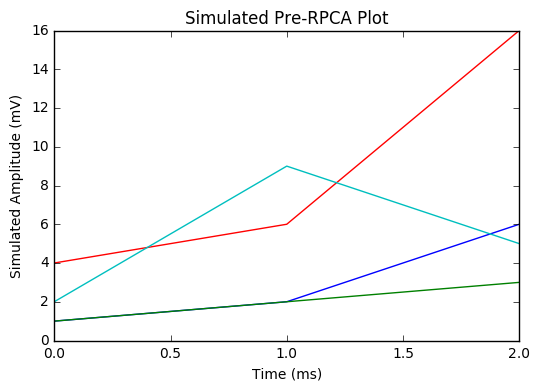

Data will be downsampled by a factor of 100 due to the maximum amount of RAM Robust PCA can handle at once
Noise reduction for patient 0
Noise reduction for trial 0


LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

In [17]:
eeg_sample_data = np.array([[[[1, 2, 6], [1, 2, 3], [4,6,16], [2,9,5]], [[1, 50, 40], [1, 2, 3], [4,7,18], [8,6,5]]], [[[1, 50, 40], [1, 2, 3], [1,1,1], [1,1,1]], [[1, 50, 40], [1, 2, 3], [1,1,1], [1,1,1]]]] , np.float32)
eeg_sample_data = eeg_sample_data.T
x = range(0,3)
plt.plot(x, eeg_sample_data[:,0,0,0])
plt.plot(x, eeg_sample_data[:,1,0,0])
plt.plot(x, eeg_sample_data[:,2,0,0])
plt.plot(x, eeg_sample_data[:,3,0,0])
plt.title("Simulated Pre-RPCA Plot")
plt.xlabel('Time (ms)')
plt.ylabel('Simulated Amplitude (mV)')
plt.show()
PostRPCA = robustPCA(eeg_sample_data, "RobustPCA")

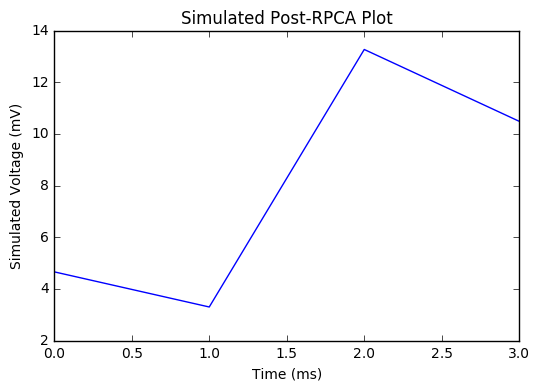

In [18]:
x = range(0,4)
y = [4.657520560178286, 3.2973284076853844, 13.265723764948405, 10.4842079373323]
plt.plot(x, y)
plt.title("Simulated Post-RPCA Plot")
plt.xlabel('Time (ms)')
plt.ylabel('Simulated Voltage (mV)')
plt.show()

In [19]:
testdata = np.zeros((200000,110,1,1))
Dance = robustPCA(testdata, "RobustPCA")

Data will be downsampled by a factor of 100 due to the maximum amount of RAM Robust PCA can handle at once
Noise reduction for patient 0
Noise reduction for trial 0


C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:67: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


The Number of Principal Components to Retain:
1


The Post-RPCA Matrix
[[-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
  -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
  -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
  -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
  -- -- -- --]]
